In [2]:
import pandas as pd
import requests
from pandas import json_normalize 
import numpy as np
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import re
import warnings
import geopandas as gpd
from shapely.geometry import Point, Polygon
import folium
from folium.plugins import MarkerCluster
import os
from pathlib import Path
from leads.data import get_save_data

# Help functions

In [3]:
def get_postcode(fulladdress):
    try:
        postcode=re.search(r'[A-Z][A-Z][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
    except Exception:
        postcode= 'nomatch' 
        try:
            postcode=re.search(r'[A-Z][A-Z][0-9][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
        except Exception:
            postcode= 'nomatch' 
            try:
                postcode=re.search(r'[A-Z][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
            except Exception:
                postcode= 'nomatch'
                try:
                    postcode=re.search(r'[A-Z][0-9][0-9]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                except Exception:
                    postcode= 'nomatch'
                    try:
                        postcode=re.search(r'[A-Z][0-9][A-Z]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                    except Exception:
                        postcode= 'nomatch'
                        try:
                            postcode=re.search(r'[A-Z][A-Z][0-9][A-Z]\s[0-9][A-Z][A-Z]', fulladdress).group(0)
                        except Exception:
                            postcode= 'nomatch'
                            try:
                                postcode=re.search(r'\s[A-Z][A-Z][0-9][0-9]', fulladdress).group(0)
                            except Exception:
                                postcode= 'nomatch'
                                try:
                                    postcode=re.search(r'\s[A-Z][A-Z][0-9]', fulladdress).group(0)
                                except Exception:
                                    postcode= 'nomatch'
                                    try:
                                        postcode=re.search(r'\s[A-Z][0-9][0-9]', fulladdress).group(0)
                                    except Exception:
                                        postcode= 'nomatch'
            
    return postcode

In [4]:
def dist(lat1, long1, lat2, long2):
    return np.abs((lat1-lat2)+(long1-long2))

In [5]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [6]:
def match_restaurant(lat, long):
    distances = df.apply(
        lambda row: haversine(lat, long, float(row['Geocode.Latitude']), float(row['Geocode.Longitude'])), 
        axis=1)
    closest=distances.min()
    if closest>0.005:
        return 'nomatch'
    else:
        return df.loc[distances.idxmin(), 'BusinessName'],closest

In [7]:
def return_paretto(df,column_name,column_name_sum,threshold):
    #df is a grouped dataframe
    
    grouped_df=df
    grouped_df=grouped_df.rename(columns={column_name_sum: "count"})
    grouped_df=grouped_df.reset_index().sort_values(by=['count'],ascending=False).reset_index(drop=True)
    
    total=grouped_df['count'].sum()
    grouped_df['percentage']=(grouped_df['count']/total)*100
    
    index_paretto=grouped_df['percentage'].cumsum().searchsorted(threshold)
    paretto_list=grouped_df[column_name][0:index_paretto+1].values.tolist()
    return grouped_df, paretto_list

# Load Uber data 

We will load Uber data provided with columns: <br>

    -Name <br>
    -Cuisine <br>
    -Address <br>
    -Latitude <br>
    -Longitude <br>
    -Average_rating <br>
    -Reviews_count <br>
    -Merchant Category <br>
    -City_name <br>
    
We extract **Post Code** with the function **_get_postcode_** and a LatLon column, which is a concatenation of latitute and longitude

In [29]:
data = pd.read_csv("../london-food-delivery/ubereats.csv")

In [30]:
original_data=data.copy()

In [31]:
data['postcode']=data['address'].apply(get_postcode)

In [32]:
data['latlon']=data.apply(
    lambda row: str(round(row['latitude'],4))+str(round(row['longitude'],4)), 
    axis=1)

## Few Insights About Uber Eats Data

Uber Eats in London has more or less 70 chains with more than 4 outlets.

In [244]:
uber_eats_chains=pd.DataFrame(data['name'].value_counts()).reset_index().rename(columns={'index':'BusinessName','name':'count'})
uber_eats_chains[uber_eats_chains['count']>4]

,BusinessName,count
0,Sandwich shop Subway,267
1,Pizza restaurant Pizza Hut Delivery,147
2,Pizza restaurant Papa John's Pizza,140
3,Takeout Restaurant Subway,89
4,Sandwich shop Pret A Manger,65
...,...,...
65,Kebab shop Best Kebab,5
66,Mexican restaurant Chipotle Mexican Grill,5
67,Cafe Sunshine Cafe,5
68,Cafe Costa Coffee,5


London Central is not where the majority of the restaurants are. A possible explanation is that usually center is more touristic(more expensive and less quality) and more walk-ins and on-the-go

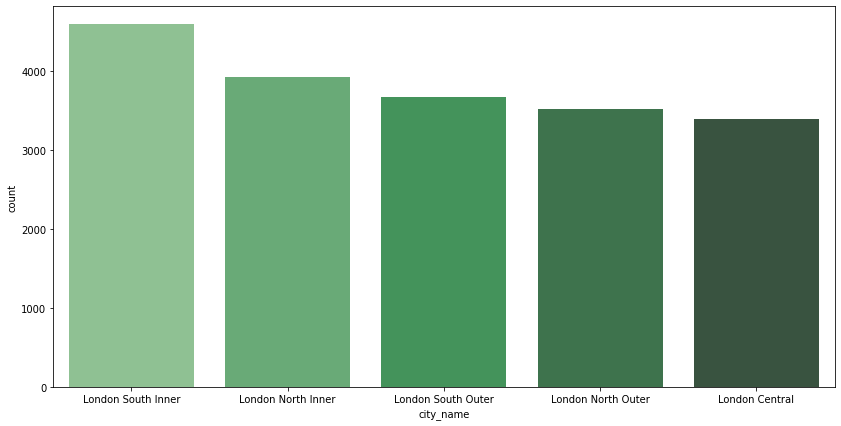

In [231]:
fig_dims = (14, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="city_name", data=data, palette="Greens_d",
              order=data.city_name.value_counts().iloc[:5].index)

# Load UK Food Standard Agency data

We will load data from the UK Food Standard Agency. It has 32 Columns, being the most important ones: <br>

    -Business Name <br>
    -Business Type <br>
    -Address <br>
    -PostCode <br>
    -Latitude <br>
    -Longitude <br>
    -Rating Value (related to hygiene) <br>
    
We add a LatLon column, which is a concatenation of latitute and longitude

In [56]:
city='london'
url = "http://ratings.food.gov.uk/search/^/%s/1/30/json"%city
response = requests.get(url).json()
page_count=int(response['FHRSEstablishment']['Header']['PageCount'])
df=json_normalize(response['FHRSEstablishment']['EstablishmentCollection']['EstablishmentDetail'])
for page in range(1,page_count):
    url = f"http://ratings.food.gov.uk/search/^/{city}/{page}/30/json"
    response = requests.get(url).json()
    df_iter = json_normalize(response['FHRSEstablishment']['EstablishmentCollection']['EstablishmentDetail'])
    df=pd.concat([df, df_iter], axis= 0)

In [33]:
#df.to_csv('/home/louisedantas/code/LouiseDantas/london-food-delivery/UKFoodAgency.csv')

In [34]:
#df=pd.read_csv('../london-food-delivery/UKFoodAgencyLondon.csv')

In [57]:
df=df.reset_index(drop=True)

In [58]:
df=df.rename(columns={"PostCode": "postcode"})
df['Geocode.Longitude']=pd.to_numeric(df['Geocode.Longitude'],downcast='float')
df['Geocode.Latitude']=pd.to_numeric(df['Geocode.Latitude'],downcast='float')
df=df.rename(columns={"Geocode.Latitude": "latitude", "Geocode.Longitude": "longitude"})

In [59]:
df['latlon']=df.apply(
    lambda row: str(round(row['latitude'],4))+str(round(row['longitude'],4)), 
    axis=1)

# Load London Census Data

We found London demographic data with some interesting information such as:
    
    -PostCode <br>
    -Latitude <br>
    -Longitude <br>
    -Average Income <br>
    -Rural/urban <br>
    -others <br>

We hope to merge with the uber dataset and UK Food Agency dataset to hopefully find  correlation among neighboorhood preferences, cuisine, income.

In [38]:
census = pd.read_csv("../london-food-delivery/London postcodes.csv")

/home/louisedantas/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [39]:
census=census.rename(columns={"Postcode": "postcode"})

In [40]:
census['latlon']=census.apply(
    lambda row: str(round(row['Latitude'],4))+str(round(row['Longitude'],4)), 
    axis=1)

# Merge census data into Uber data and UK Food Agency data

We are adding avegerage income and london zone for every postcode 

In [80]:
data=data.merge(census[['London zone','postcode','ITL level 2','Average Income']],how='left',on=['postcode'])

In [81]:
df=df.merge(census[['London zone','postcode','ITL level 2','Average Income']],how='left',on=['postcode'])

# Find restaurants are not in Uber Eats

Now that we have the two datasets: <br>
    
    1.London Ubereats Restaurants
    2.UK Food Agency data
We will identify London restaurants that are not in Uber Eats Platform.

We did that by matching the latitude and longitude to identify common restaurants. The accuracy used is 11 meters.


## London Restaurants in Uber eats

In [65]:
incommon_df = df.merge(data,on=['latlon'])

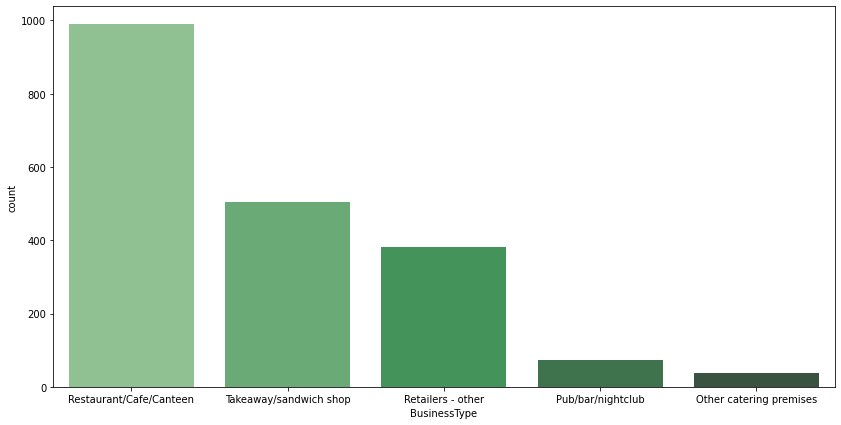

In [228]:
fig_dims = (14, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="BusinessType", data=incommon_df, palette="Greens_d",
              order=incommon_df.BusinessType.value_counts().iloc[:5].index)

In [69]:
#uber_latlon=data['latlon']
#match_uber=df[df['latlon'].isin(uber_latlon)].copy()
#not_uber=df[~df['latlon'].isin(uber_latlon)].copy()
uber_latlon=incommon_df['latlon']
not_uber=df[~df['latlon'].isin(uber_latlon)].copy()

In [116]:
not_uber

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Distance.@xsi:nil,Scores.Hygiene.@xsi:nil,Scores.Structural.@xsi:nil,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone,ITL level 2,Average Income
0,468824,1317,"""Rio Cinema""",Restaurant/Cafe/Canteen,1,Rio Cinema Dalston,103-107 Kingsland High Street,London,None,E8 2PB,...,true,NaN,NaN,NaN,NaN,NaN,51.5495-0.0756,2.0,Inner London - East,56000.0
1,1177669,19/00376/COMM,% Arabica,Takeaway/sandwich shop,7844,Basement And Ground Floor,5 King Street,Covent Garden,London,WC2E 8HN,...,true,NaN,NaN,NaN,NaN,NaN,51.5117-0.124,1.0,Inner London - West,59000.0
2,1220366,191074,% Arabica,Manufacturers/packers,7839,Railway Arch 214,Ponsford Street,Hackney,London,E9 6JU,...,true,NaN,NaN,NaN,NaN,NaN,51.5473-0.0485,2.0,Inner London - East,52200.0
3,1225476,130435,%Arabica,Other catering premises,7841,Basement To Ground Floor,33 Broadway Market,Hackney,London,E8 4PH,...,true,NaN,NaN,NaN,NaN,NaN,51.5365-0.0621,2.0,Inner London - East,56900.0
4,463541,PI/000187321,( Pitches 46 & 47 & 48)Jean Hogg,Retailers - other,4613,Lewisham Market,Lewisham High Street,Hither Green,London,SE13 6JG,...,true,NaN,NaN,NaN,NaN,NaN,51.462-0.0108,2.0,Inner London - East,50700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43824,495898,12/00225/COMM,Zula Cafe,Restaurant/Cafe/Canteen,1,Shop,189 Ferndale Road,London,None,SW9 8BA,...,true,NaN,NaN,NaN,NaN,NaN,51.4639-0.1164,2.0,Inner London - East,67300.0
43825,428126,01521/0005/0/000,Zuma,Restaurant/Cafe/Canteen,1,5 Raphael Street,London,None,None,SW7 1DL,...,true,NaN,NaN,NaN,NaN,NaN,51.5009-0.1629,1.0,Inner London - West,56300.0
43826,1246213,20/00197/COMM,Zumak39,Restaurant/Cafe/Canteen,1,39 Panton Street,London,None,None,SW1Y 4EA,...,true,NaN,NaN,NaN,NaN,NaN,51.5096-0.1319,1.0,Inner London - West,59000.0
43827,894118,13/00338/COMM,Zumbura,Restaurant/Cafe/Canteen,1,Business,36A Old Town,London,None,SW4 0LB,...,true,NaN,NaN,NaN,NaN,NaN,51.4642-0.1418,2.0,Inner London - East,66000.0


# Narrowingdown leads list - From 42k addresses to 4800

## Criteria 1: Most Ordered Categories in Uber

Our rationale is to identify most ordered categories (Merchant Category column) by uber eats london customers and select these categories in the UK Food Agency data.

Ideally we would want to see the average price ticket for each restaurant so we could select categories which give 80% of the total revenue of Uber eats. Since we do not have price ticket we will use pure volume instead.

Well, below you will see the most ordered (80%) categories are: <br>
[restaurants, bars]

Since Uber Merchant Categories are not the same as London Food Agency Categories, we need to map their relation.

In order to do that we used the merged df of in common restaurants.

The most ordered categories [restaurant, bars] in Uber eats correspond to the category of:<br>

    1.Takeaway/sandwich shop
    2.Retailers - other 
    3.Restaurant/Cafe/Canteen 
    4.Pub/bar/nightclub 
    5.Retailers - supermarkets/hypermarkets 
    6.Hotel/bed & breakfast/guest house 
    7.Mobile caterer 
    8.Manufacturers/packers 
    9.Other catering premises 
    10.Distributors/Transporters 
    11.School/college/university 
    
**We selected these 11 categories above and our non-uber list narrowed down only by 5%. So we will apply a second criteria**

In [117]:
uber_cat_most_ordered=pd.DataFrame(data.groupby(['merchant_category'])['reviews_count'].sum())
(uber_cat_most_ordered,most_ordered_list)=return_paretto(uber_cat_most_ordered,'merchant_category','reviews_count',80)

In [118]:
uber_cat_most_ordered

,merchant_category,count,percentage
0,restaurants,11407842.0,79.371733
1,bars,754152.0,5.247123
2,cafes,646746.0,4.499830
3,fish and chips takeaway,255462.0,1.777414
4,fried chicken takeaway,221382.0,1.540298
...,...,...,...
58,hot dog restaurant,12.0,0.000083
59,restaurant or cafe,12.0,0.000083
60,hong kong style fast food restaurant,12.0,0.000083
61,hamburgerrestaurant,6.0,0.000042


In [119]:
businesstype_list=incommon_df[incommon_df['merchant_category'].isin(most_ordered_list)]['BusinessType'].unique()

## Criterea 2: Number of Outlets

We selected the most oredered categories and our non-uber list narrowed down only by 5%.
So we will continue to apply our **Volume Criteria**:

  **_We will focus on chains. Restaurants that have more than 4 outlets in London_**
  
Chains brings more volume than a single outlet, less effort for Uber Sales Team, is also popular among Tourists.

Doing that, our leads list narrowed down to ~5000 addresses, being only 338 Restaurant Brands.

Meaning an median of 8 outlets and a mean of 14.

In [120]:
businesstype_list=incommon_df[incommon_df['merchant_category'].isin(most_ordered_list)]['BusinessType'].unique()

In [121]:
not_uber_filtered=not_uber[not_uber['BusinessType'].isin(businesstype_list)]

In [122]:
chains_df=pd.DataFrame(not_uber[not_uber['BusinessType'].isin(businesstype_list)]['BusinessName'].value_counts())

In [123]:
chains_df[chains_df['BusinessName']>4]

,BusinessName
Tesco,244
Sainsbury's,195
Pret A Manger,167
Costa Coffee,137
Subway,126
...,...
Patty & Bun,5
Nando's Chickenland,5
Food & Wine,5
Wok To Walk,5


In [124]:
chains_list=chains_df[chains_df['BusinessName']>4].reset_index()['index'].values.tolist()
leads_hot_list=df[df['BusinessName'].isin(chains_list)]

In [126]:
leads_hot_list

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y
629,1425783,PI/000162323,Admiral,Retailers - other,4613,Shop,513 Green Lanes,Hornsey,London,N4 1AN,...,NaN,NaN,NaN,51.5816-0.0999,3.0,Inner London - East,50000.0,3.0,Inner London - East,50000.0
630,1081580,PI/000139926,Admiral,Other catering premises,7841,9 High Road,Wood Green,London,None,N22 6BH,...,NaN,NaN,NaN,51.5911-0.1045,3.0,Inner London - East,43800.0,3.0,Inner London - East,43800.0
631,208337,1996/00211/COMM,Admiral,Other catering premises,7841,10 London Road,Brighton,None,None,BN1 4JA,...,NaN,NaN,NaN,50.8302-0.1364,NaN,NaN,NaN,NaN,NaN,NaN
632,1418320,HAC0956,Admiral,Restaurant/Cafe/Canteen,1,165 Stoke Newington High Street,None,Hackney,London,N16 0NY,...,true,NaN,NaN,51.5616-0.074,2.0,Inner London - East,57000.0,2.0,Inner London - East,57000.0
633,416626,PI/000094412,Admiral,Restaurant/Cafe/Canteen,1,Admiral,3 Seven Sisters Road,Islington,London,N7 6AJ,...,true,NaN,NaN,51.5582-0.1192,2.0,Inner London - East,52700.0,2.0,Inner London - East,52700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43803,428139,01576/0073/0/002,Zizzi,Restaurant/Cafe/Canteen,1,73-75 Strand,London,None,None,WC2R 0DE,...,NaN,NaN,NaN,51.51-0.1221,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
43804,428193,06/00048/COMM,Zizzi,Restaurant/Cafe/Canteen,1,15 Cardinal Walk,London,None,None,SW1E 5JE,...,NaN,NaN,NaN,51.4974-0.1416,1.0,Inner London - West,57500.0,1.0,Inner London - West,57500.0
43805,814272,2015/00192/COMB,Zizzi,Restaurant/Cafe/Canteen,1,Unit 1070A,Westfield London Shopping Centre,Ariel Way,London,W12 7GB,...,NaN,NaN,NaN,51.5076-0.2213,2.0,Inner London - West,50100.0,2.0,Inner London - West,50100.0
43806,86257,22,Zizzi,Restaurant/Cafe/Canteen,1,Unit 12 Ivory House,East Smithfield,London,None,E1W 1AT,...,NaN,NaN,NaN,51.5072-0.0718,1.0,Inner London - East,70900.0,1.0,Inner London - East,70900.0


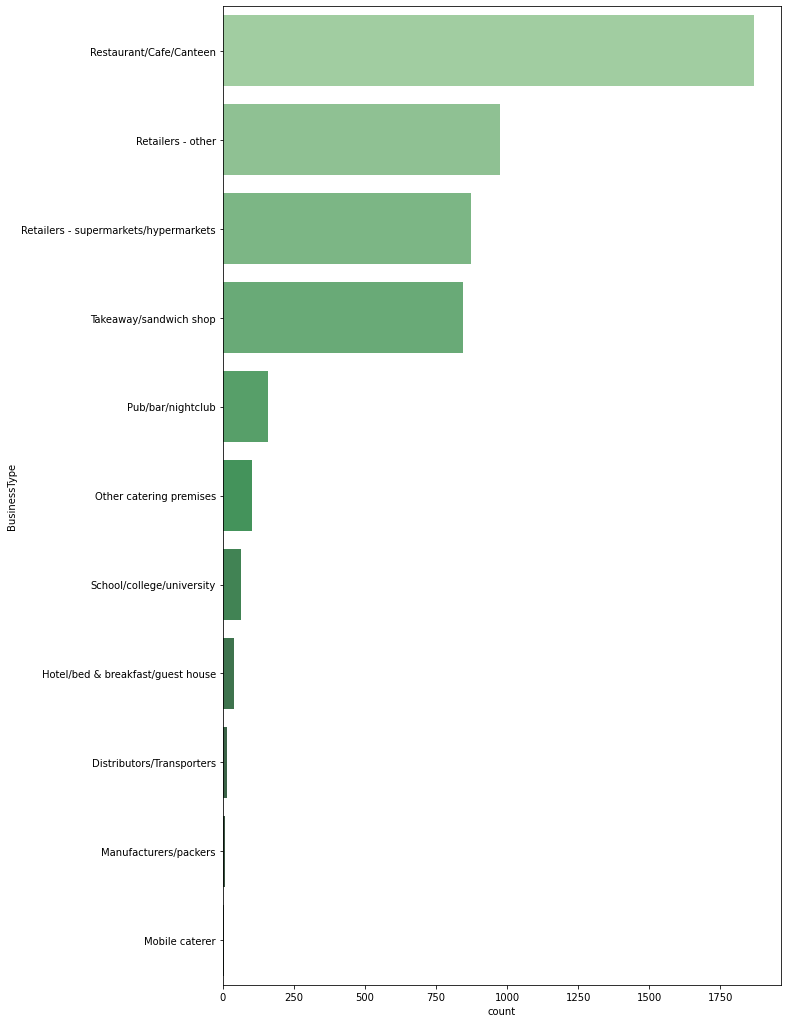

In [135]:
fig_dims = (10, 18)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(y="BusinessType", data=leads_hot_list, palette="Greens_d",
              order=leads_hot_list.BusinessType.value_counts().index)

In [187]:
leads_hot_list=leads_hot_list[~leads_hot_list['RatingValue'].isin(['0','1','2'])]

# FINAL LEADS LIST

We have **338 Chains as hot leads**. We see that some of them are already in Uber Eats, but not all outlets(addresses). For example, we see Costa Coffee is on Uber Eats, but we see some outlets that are not. There might be a good reason for it (if its in an airport location for example) but also might be an opportunity to onboard different locations of existing restaurants.
Thats why we decided to keep them in our leads list.

We can suggest by contacting these outlets first. Since the restaurant is already in Uber, perhaps its easier to onboard the remaining addresses.

On 8.1 you see all Addresses of our Leads Hot List. 

On 8.2 theres a split. 43 Chains are already in Uber Eats and 295 are new to Uber Eats

## All Addresses of leads list

In [191]:
leads_hot_list[['BusinessName','AddressLine1','AddressLine2','AddressLine3','AddressLine4','postcode','RatingValue','RatingDate','London zone_x','ITL level 2_x','Average Income_x']]

,BusinessName,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,RatingValue,RatingDate,London zone_x,ITL level 2_x,Average Income_x
629,Admiral,Shop,513 Green Lanes,Hornsey,London,N4 1AN,5,07 February 2022,3.0,Inner London - East,50000.0
630,Admiral,9 High Road,Wood Green,London,None,N22 6BH,5,24 August 2018,3.0,Inner London - East,43800.0
631,Admiral,10 London Road,Brighton,None,None,BN1 4JA,5,19 March 2015,NaN,NaN,NaN
632,Admiral,165 Stoke Newington High Street,None,Hackney,London,N16 0NY,AwaitingInspection,N/A,2.0,Inner London - East,57000.0
633,Admiral,Admiral,3 Seven Sisters Road,Islington,London,N7 6AJ,Exempt,N/A,2.0,Inner London - East,52700.0
...,...,...,...,...,...,...,...,...,...,...,...
43803,Zizzi,73-75 Strand,London,None,None,WC2R 0DE,5,18 September 2019,1.0,Inner London - West,59000.0
43804,Zizzi,15 Cardinal Walk,London,None,None,SW1E 5JE,5,07 October 2019,1.0,Inner London - West,57500.0
43805,Zizzi,Unit 1070A,Westfield London Shopping Centre,Ariel Way,London,W12 7GB,4,11 October 2017,2.0,Inner London - West,50100.0
43806,Zizzi,Unit 12 Ivory House,East Smithfield,London,None,E1W 1AT,4,08 November 2019,1.0,Inner London - East,70900.0


## We have 43 Chains that are already in Uber, and 295 Chains new to Uber

In [282]:
forbidden=['restaurant','coffee','Company','restaurants','cafe','bar']
uber_chains=data['name'].unique()

In [284]:
uber_chain_string=[]
for elem in uber_chains:
    elem=str(elem)
    uber_chain_string.append(elem)

In [288]:
uber_chains_reduced=[]
for rest in uber_chain_string:
    querywords=rest.split()

    resultwords  = [word for word in querywords if word.lower() not in forbidden]
    result = ' '.join(resultwords)
    uber_chains_reduced.append(result)
    
chains_list_reduced=[]
for rest in chains_list:
    querywords=rest.split()

    resultwords  = [word for word in querywords if word.lower() not in forbidden]
    result = ' '.join(resultwords)
    chains_list_reduced.append(result)

In [291]:
in_common_list=[]
for item1 in uber_chains_reduced:
    for item2 in chains_list_reduced:
        if item1 == item2:
            in_common_list.append(item1)

In [292]:
len(in_common_list)

43

# Explore Leads List

In [192]:
leads_df=leads_hot_list[['BusinessName','AddressLine1','AddressLine2','AddressLine3','AddressLine4','postcode','RatingValue','RatingDate','London zone_x','ITL level 2_x','Average Income_x']]

Where are the leads located

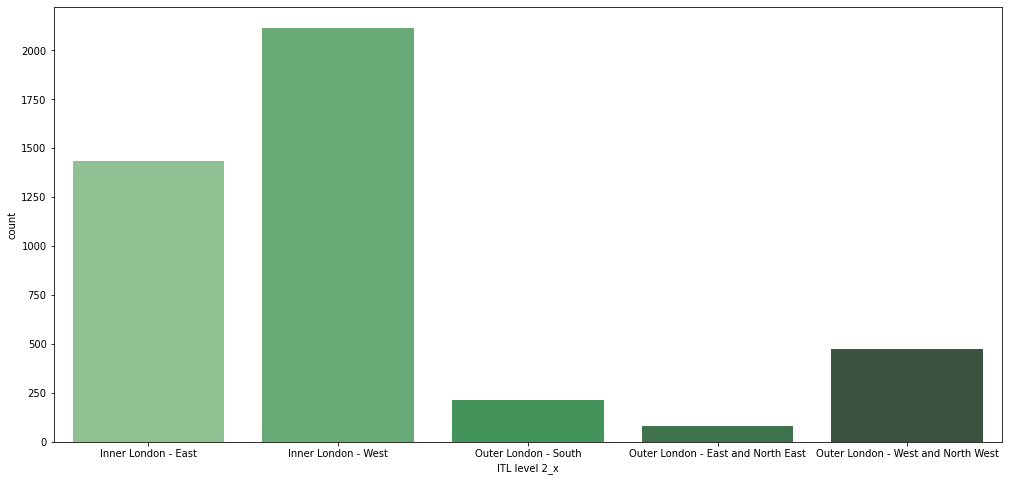

In [199]:
fig_dims = (17, 8)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="ITL level 2_x", data=leads_df, palette="Greens_d")

Hygiene Rating. Good too see not many are waiting inspection

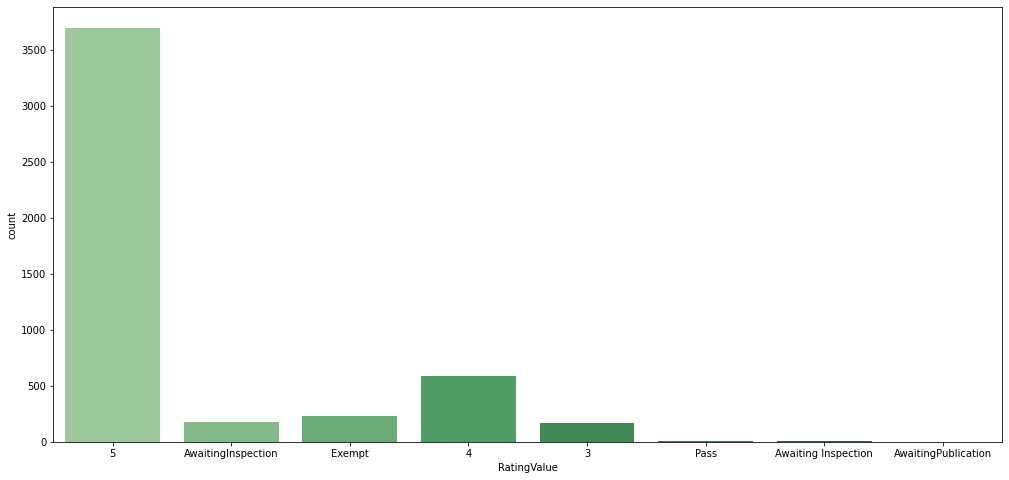

In [200]:
fig_dims = (17, 8)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="RatingValue", data=leads_df, palette="Greens_d")

In [201]:
pd.DataFrame(leads_df.groupby(['BusinessName'])['Average Income_x'].mean())

,Average Income_x
BusinessName,
AMT Coffee,58216.666667
Admiral,50040.000000
Admiral Casino,49471.428571
Aldi,55571.428571
All Bar One,61731.578947
...,...
You Me Sushi,50742.857143
Zapp,55007.692308
Zia Lucia,64300.000000


In [221]:
leads_count=pd.DataFrame(leads_df['BusinessName'].value_counts()).reset_index().rename(columns={'BusinessName':'count'}).rename(columns={'index':'BusinessName'})
leads_income=pd.DataFrame(leads_df.groupby(['BusinessName'])['Average Income_x'].mean()).reset_index().sort_values(['Average Income_x'],ascending=False)
leads_income=leads_income.merge(leads_count,on='BusinessName')



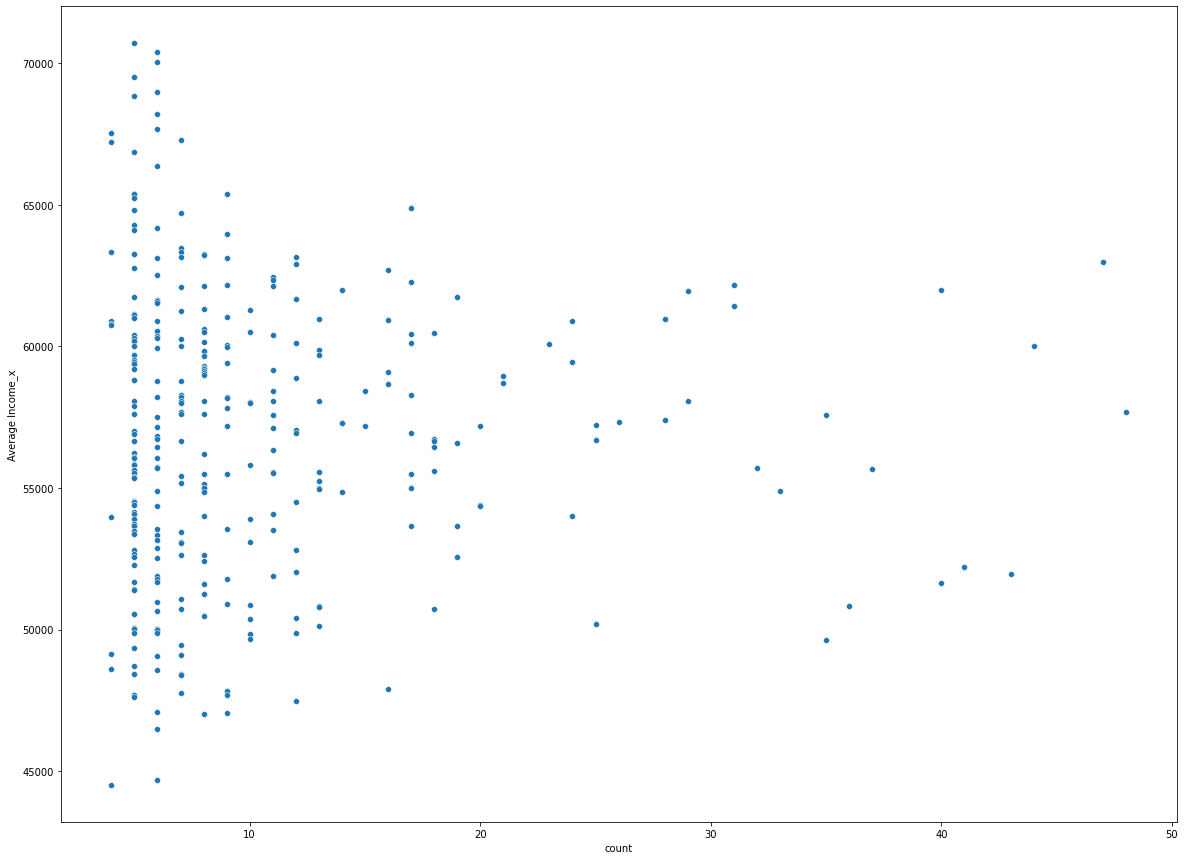

In [225]:

fig_dims = (20, 15)
fig = plt.subplots(figsize=fig_dims)
fig=sns.scatterplot(data=leads_income[leads_income['count']<50],x='count',y='Average Income_x')


******END**********

# Appendix - Analysis that didnt work; some Insights

## Does neighboorhood with high average income Order More?

That doesnt seem to be the case. My initial assumption was to filter by a threashold on income, and select restaurants from specifics postcodes.
But the data shows I shouldnt do that.

[(0.0, 22000.0)]

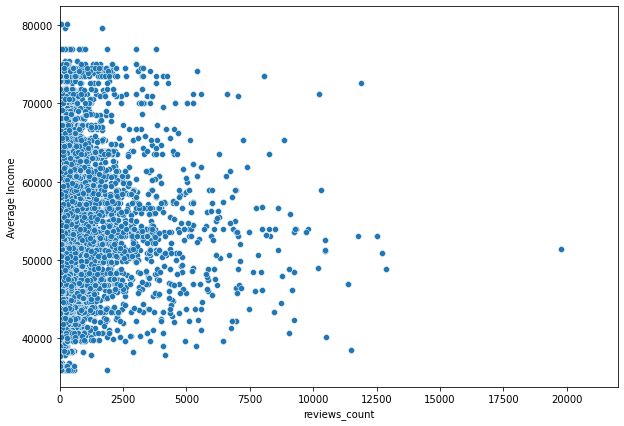

In [82]:
fig_dims = (10, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.scatterplot(data=data,x='reviews_count',y='Average Income')
fig.set(xlim=(0,22000))

## Is there a specific neighboorhood that people order more?

Most Ordered (reviewed) restaurants are in zones 1,3 and 4. Suming up to 66% of all the reviews.

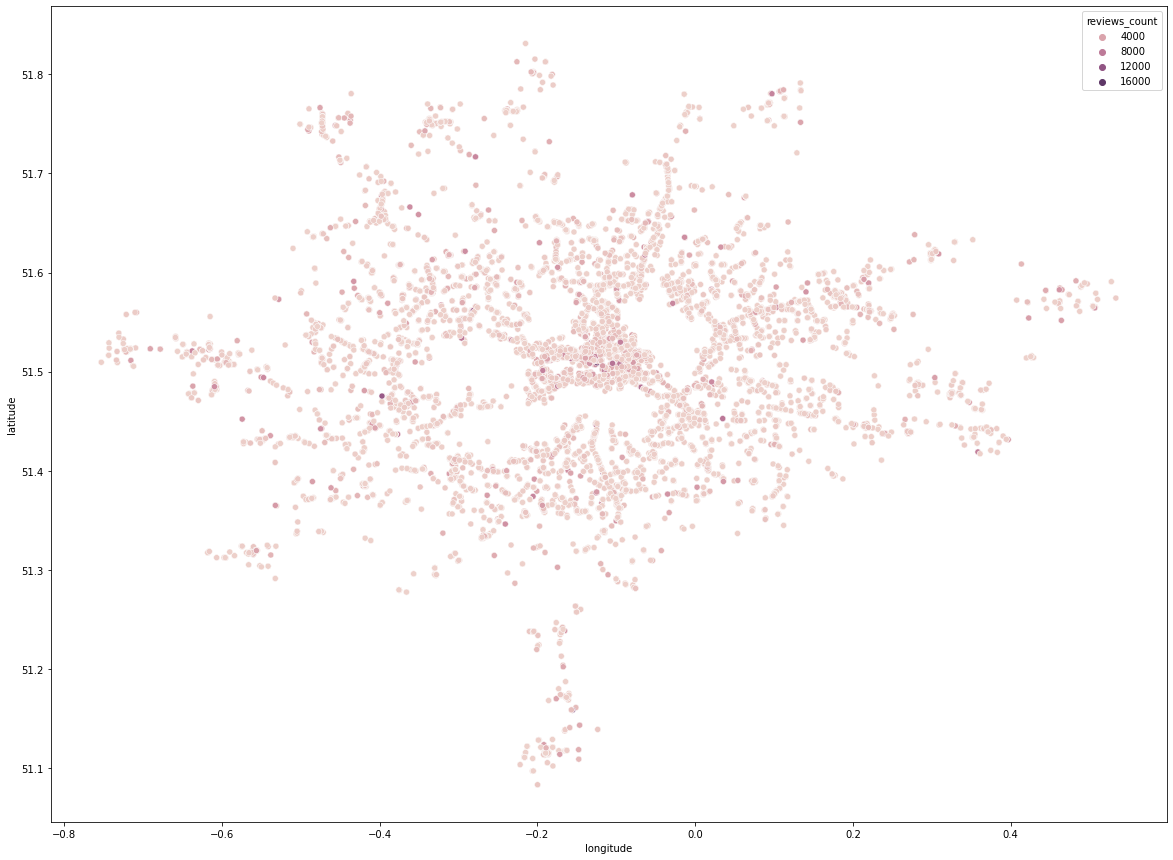

In [83]:
fig_dims = (20, 15)
fig = plt.subplots(figsize=fig_dims)
fig=sns.scatterplot(data=data[data['reviews_count']<22000],x='longitude',y='latitude',hue='reviews_count')
#fig.set(xlim=(0,22000))

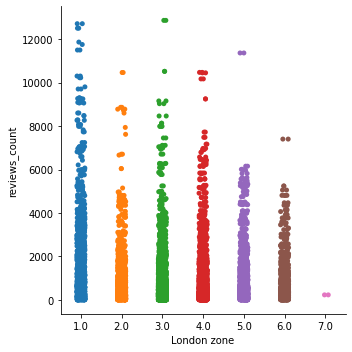

In [84]:
sns.catplot(x='London zone', y='reviews_count',data=data[data['reviews_count']<15000])

In [85]:
orders_per_zone=pd.DataFrame(data.groupby(['London zone'])['reviews_count'].sum())
(orders_per_zone,zonemost_ordered_list)=return_paretto(orders_per_zone,'London zone','reviews_count',80)

In [86]:
orders_per_zone

,London zone,count,percentage
0,4.0,2436516.0,22.433819
1,1.0,2407872.0,22.170084
2,3.0,2273232.0,20.930409
3,5.0,1579320.0,14.541328
4,2.0,1197462.0,11.025434
5,6.0,966042.0,8.894672
6,7.0,462.0,0.004254


## Any correlation between Income and Zone?

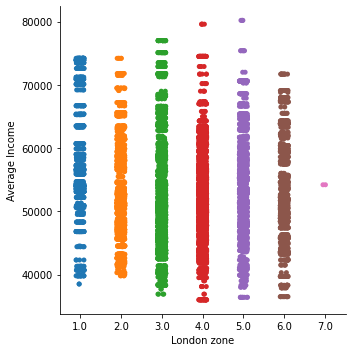

In [87]:
sns.catplot(x='London zone', y='Average Income',data=data)

## Which London Zone are chains located?

In [89]:
df

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y
0,468824,1317,"""Rio Cinema""",Restaurant/Cafe/Canteen,1,Rio Cinema Dalston,103-107 Kingsland High Street,London,None,E8 2PB,...,NaN,NaN,NaN,51.5495-0.0756,2.0,Inner London - East,56000.0,2.0,Inner London - East,56000.0
1,1177669,19/00376/COMM,% Arabica,Takeaway/sandwich shop,7844,Basement And Ground Floor,5 King Street,Covent Garden,London,WC2E 8HN,...,NaN,NaN,NaN,51.5117-0.124,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
2,1220366,191074,% Arabica,Manufacturers/packers,7839,Railway Arch 214,Ponsford Street,Hackney,London,E9 6JU,...,NaN,NaN,NaN,51.5473-0.0485,2.0,Inner London - East,52200.0,2.0,Inner London - East,52200.0
3,1225476,130435,%Arabica,Other catering premises,7841,Basement To Ground Floor,33 Broadway Market,Hackney,London,E8 4PH,...,NaN,NaN,NaN,51.5365-0.0621,2.0,Inner London - East,56900.0,2.0,Inner London - East,56900.0
4,463541,PI/000187321,( Pitches 46 & 47 & 48)Jean Hogg,Retailers - other,4613,Lewisham Market,Lewisham High Street,Hither Green,London,SE13 6JG,...,NaN,NaN,NaN,51.462-0.0108,2.0,Inner London - East,50700.0,2.0,Inner London - East,50700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43825,428126,01521/0005/0/000,Zuma,Restaurant/Cafe/Canteen,1,5 Raphael Street,London,None,None,SW7 1DL,...,NaN,NaN,NaN,51.5009-0.1629,1.0,Inner London - West,56300.0,1.0,Inner London - West,56300.0
43826,1246213,20/00197/COMM,Zumak39,Restaurant/Cafe/Canteen,1,39 Panton Street,London,None,None,SW1Y 4EA,...,NaN,NaN,NaN,51.5096-0.1319,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
43827,894118,13/00338/COMM,Zumbura,Restaurant/Cafe/Canteen,1,Business,36A Old Town,London,None,SW4 0LB,...,NaN,NaN,NaN,51.4642-0.1418,2.0,Inner London - East,66000.0,2.0,Inner London - East,66000.0
43828,640333,10/00058/FOOD,Zus Sizzlers,Takeaway/sandwich shop,7844,83 Green Street,Forest Gate,London,None,E7 8JF,...,NaN,NaN,NaN,51.54460.0322,3.0,Inner London - East,49500.0,3.0,Inner London - East,49500.0


<AxesSubplot:xlabel='London zone_x', ylabel='count'>

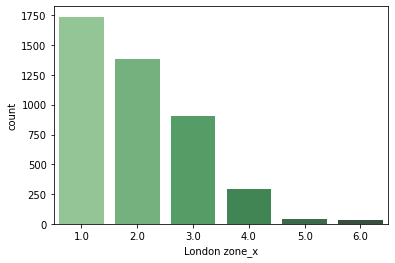

In [90]:
chains_df=df[df['BusinessName'].isin(chains_list)]
sns.countplot(x="London zone_x", data=chains_df, palette="Greens_d")

In [91]:
chains_df=pd.DataFrame(df[df['BusinessType'].isin(chains_list)]['BusinessName'].value_counts())

## Is there any correlation among review score from UK Food Agency and Uber eats review score?

<AxesSubplot:xlabel='average_rating', ylabel='RatingValue'>

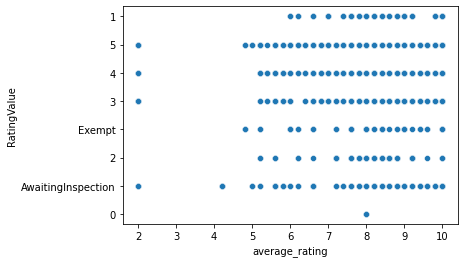

In [92]:
sns.scatterplot(data=incommon_df,x='average_rating',y='RatingValue')

<AxesSubplot:xlabel='average_rating', ylabel='Scores.Hygiene'>

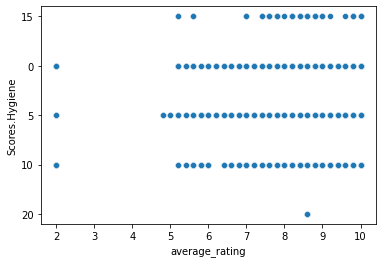

In [93]:
sns.scatterplot(data=incommon_df,x='average_rating',y='Scores.Hygiene')

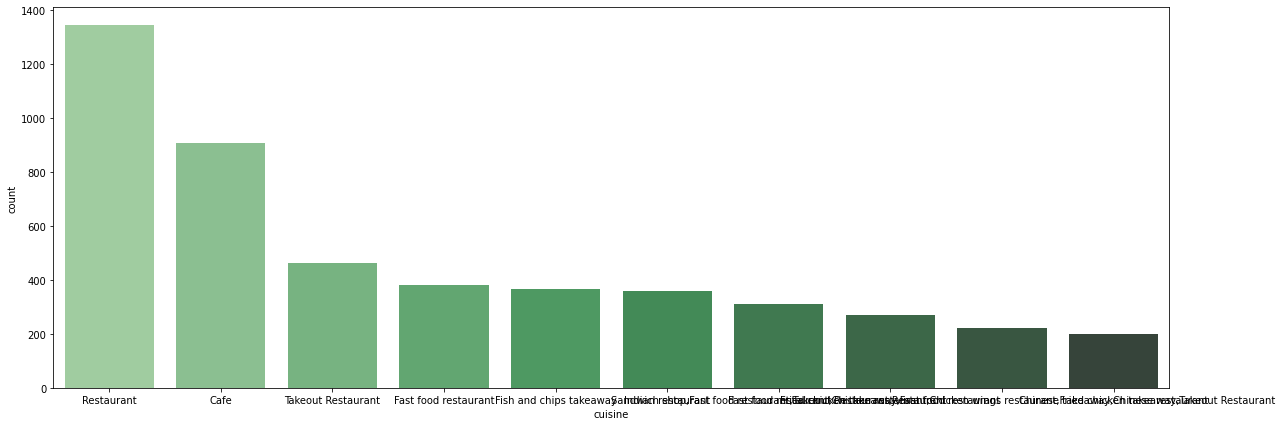

In [94]:
fig_dims = (20, 7)
fig = plt.subplots(figsize=fig_dims)
fig=sns.countplot(x="cuisine", data=data, palette="Greens_d",
              order=data.cuisine.value_counts().iloc[0:10].index)

In [95]:
data

,name,cuisine,address,latitude,longitude,average_rating,reviews_count,merchant_category,city_name,postcode,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y,London zone,ITL level 2,Average Income
0,Cocktail bar Kosmopol,"Cocktail bar,Bar,Event venue,Night club","138 Fulham Rd, South Kensington, London SW10 9...",51.487325,-0.178956,8.6,453.0,bars,London Central,SW10 9PY,51.4873-0.179,1.0,Inner London - West,63300.0,1.0,Inner London - West,63300.0,1.0,Inner London - West,63300.0
1,Restaurant Perfect Fried Chicken Eltham - 44 E...,"Restaurant,Fast food restaurant,Fried chicken ...","44 Eltham High St, London SE9 1BT, United Kingdom",51.451042,0.050607,8.6,216.0,restaurants,London South Inner,SE9 1BT,51.4510.0506,4.0,Outer London - East and North East,52800.0,4.0,Outer London - East and North East,52800.0,4.0,Outer London - East and North East,52800.0
2,Kebab shop Reigate Kebab Centre,Kebab shop,"6 London Rd, Reigate RH2 9HY, United Kingdom",51.238351,-0.209680,7.2,288.0,restaurants,London South Outer,RH2 9HY,51.2384-0.2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hot dog restaurant Oprha Dogs,Hot dog restaurant,"42 Newington Causeway, London SE1 6DR, United ...",51.498652,-0.098597,10.0,6.0,hot dog restaurant,London Central,SE1 6DR,51.4987-0.0986,1.0,Inner London - East,56600.0,1.0,Inner London - East,56600.0,1.0,Inner London - East,56600.0
4,Restaurant Kings Doner Kebab,Restaurant,"738 Green Ln, Dagenham RM8 1YX, United Kingdom",51.562614,0.120967,7.4,60.0,restaurants,London North Inner,RM8 1YX,51.56260.121,4.0,Outer London - East and North East,40800.0,4.0,Outer London - East and North East,40800.0,4.0,Outer London - East and North East,40800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19092,Delivery Restaurant Salt & Vinegar,"Delivery Restaurant,Fish and chips takeaway,Ta...","17 Church St, Staines TW18 4EN, United Kingdom",51.433873,-0.513896,7.6,162.0,fish and chips takeaway,London South Outer,TW18 4EN,51.4339-0.5139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19093,Chicken restaurant Selekt Chicken,Chicken restaurant,"22 Cippenham Ln, Slough SL1 5BS, United Kingdom",51.518997,-0.634023,7.4,144.0,restaurants,London South Outer,SL1 5BS,51.519-0.634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19094,Fried chicken takeaway Koleey,Fried chicken takeaway,"Mollison Square, Wallington SM6 9DA, United Ki...",51.353401,-0.134395,8.6,129.0,fried chicken takeaway,London South Inner,SM6 9DA,51.3534-0.1344,5.0,Outer London - South,44600.0,5.0,Outer London - South,44600.0,5.0,Outer London - South,44600.0
19095,Sandwich shop Subway,"Sandwich shop,Fast food restaurant,Takeout Res...","Lakeside Retail Park Unit A5, Grays RM20 1WN, ...",51.486095,0.278740,7.8,855.0,restaurants,London North Outer,RM20 1WN,51.48610.2787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y
0,468824,1317,"""Rio Cinema""",Restaurant/Cafe/Canteen,1,Rio Cinema Dalston,103-107 Kingsland High Street,London,None,E8 2PB,...,NaN,NaN,NaN,51.5495-0.0756,2.0,Inner London - East,56000.0,2.0,Inner London - East,56000.0
1,1177669,19/00376/COMM,% Arabica,Takeaway/sandwich shop,7844,Basement And Ground Floor,5 King Street,Covent Garden,London,WC2E 8HN,...,NaN,NaN,NaN,51.5117-0.124,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
2,1220366,191074,% Arabica,Manufacturers/packers,7839,Railway Arch 214,Ponsford Street,Hackney,London,E9 6JU,...,NaN,NaN,NaN,51.5473-0.0485,2.0,Inner London - East,52200.0,2.0,Inner London - East,52200.0
3,1225476,130435,%Arabica,Other catering premises,7841,Basement To Ground Floor,33 Broadway Market,Hackney,London,E8 4PH,...,NaN,NaN,NaN,51.5365-0.0621,2.0,Inner London - East,56900.0,2.0,Inner London - East,56900.0
4,463541,PI/000187321,( Pitches 46 & 47 & 48)Jean Hogg,Retailers - other,4613,Lewisham Market,Lewisham High Street,Hither Green,London,SE13 6JG,...,NaN,NaN,NaN,51.462-0.0108,2.0,Inner London - East,50700.0,2.0,Inner London - East,50700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43825,428126,01521/0005/0/000,Zuma,Restaurant/Cafe/Canteen,1,5 Raphael Street,London,None,None,SW7 1DL,...,NaN,NaN,NaN,51.5009-0.1629,1.0,Inner London - West,56300.0,1.0,Inner London - West,56300.0
43826,1246213,20/00197/COMM,Zumak39,Restaurant/Cafe/Canteen,1,39 Panton Street,London,None,None,SW1Y 4EA,...,NaN,NaN,NaN,51.5096-0.1319,1.0,Inner London - West,59000.0,1.0,Inner London - West,59000.0
43827,894118,13/00338/COMM,Zumbura,Restaurant/Cafe/Canteen,1,Business,36A Old Town,London,None,SW4 0LB,...,NaN,NaN,NaN,51.4642-0.1418,2.0,Inner London - East,66000.0,2.0,Inner London - East,66000.0
43828,640333,10/00058/FOOD,Zus Sizzlers,Takeaway/sandwich shop,7844,83 Green Street,Forest Gate,London,None,E7 8JF,...,NaN,NaN,NaN,51.54460.0322,3.0,Inner London - East,49500.0,3.0,Inner London - East,49500.0


In [100]:
df.count()

FHRSID                                    43830
LocalAuthorityBusinessID                  43830
BusinessName                              43830
BusinessType                              43830
BusinessTypeID                            43830
AddressLine1                              34845
AddressLine2                              40756
AddressLine3                              28089
AddressLine4                              15377
postcode                                  43140
RatingValue                               43830
RatingKey                                 43830
RightToReply                                  6
RatingDate                                43830
LocalAuthorityCode                        43830
LocalAuthorityName                        43830
LocalAuthorityWebSite                     43830
LocalAuthorityEmailAddress                43830
SchemeType                                43830
NewRatingPending                          43830
Scores.Hygiene                          

In [106]:
teste=df.copy()

In [108]:
teste=teste.dropna(subset=['AddressLine2'])

In [110]:
teste[teste["AddressLine2"].str.contains("138 Fulham")]

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y


In [137]:
leads_hot_list['BusinessType'].unique()

array(['Retailers - other', 'Other catering premises',
       'Restaurant/Cafe/Canteen', 'Retailers - supermarkets/hypermarkets',
       'Pub/bar/nightclub', 'Takeaway/sandwich shop',
       'Manufacturers/packers', 'School/college/university',
       'Mobile caterer', 'Distributors/Transporters',
       'Hotel/bed & breakfast/guest house'], dtype=object)

In [140]:
leads_hot_list[leads_hot_list['BusinessType']=='Retailers - supermarkets/hypermarkets']['BusinessName'].unique()

array(['Aldi', 'Asda', 'Best One', 'Budgens', 'Clockwork Pharmacy',
       'Co-op', 'Co-Op', 'Co-op Food', 'Co-operative',
       'Co-operative Food', 'Corner Shop', 'Costcutter',
       'Costcutter Express', 'Costcutters', 'Food & Wine',
       'Getir UK Limited', 'Gorillas Technologies Ltd', 'Iceland',
       'Iceland Foods', 'Iceland Foods Ltd', 'Jiffy Grocery', 'Lidl',
       'Little Waitrose', 'Londis', 'Marks & Spencer',
       'Marks & Spencer Simply Food', 'Marks & Spencer Simply Foods',
       'Marks And Spencer', 'McColls', 'Morrisons', 'Nisa', 'Nisa Local',
       'Poundland', 'Pret A Manger', "Sainsbury's", "Sainsbury's Local",
       "Sainsbury's Supermarkets Ltd", 'Sainsburys',
       'Savers Health & Beauty', 'Shell Service Station', 'Superdrug',
       'Supersave', 'Sushi Daily', 'Tesco', 'Tesco Express',
       'Tesco Metro', 'The Co-operative', 'The Co-operative Food',
       'The Coop', 'The Corner Shop', 'Waitrose', 'Waitrose Ltd', 'Weezy',
       'Wilko', 'Zapp'], 

In [177]:
df['RatingValue'].unique()

array(['5', '4', '2', 'AwaitingInspection', '3', 'Exempt', '1', 'Pass',
       '0', 'Awaiting Inspection', 'Improvement Required',
       'AwaitingPublication'], dtype=object)

In [183]:
df[df['RatingValue']=='0'][['Scores.Hygiene','RatingValue','BusinessName']]

,Scores.Hygiene,RatingValue,BusinessName
258,20,0,84 West Brasserie & Grill
841,15,0,Al Badar Fried Chicken & Curry
868,20,0,Al Kababgi Mezze & Grill
895,15,0,Al Rehman Halal Meat
905,20,0,Al Wadi
...,...,...,...
39614,20,0,The Sussex Peasant
42296,25,0,West Ealing Halal Meat & Grocers
42982,20,0,Wok N Pie
43664,20,0,Zana Food Centre


In [247]:
data[data['name']=='Cafe Costa Coffee']

,name,cuisine,address,latitude,longitude,average_rating,reviews_count,merchant_category,city_name,postcode,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y,London zone,ITL level 2,Average Income
270,Cafe Costa Coffee,Cafe,"197 New Kent Rd, London SE1 4AG, United Kingdom",51.494357,-0.090465,10.0,15.0,cafes,London Central,SE1 4AG,51.4944-0.0905,1.0,Inner London - East,54700.0,1.0,Inner London - East,54700.0,1.0,Inner London - East,54700.0
4588,Cafe Costa Coffee,"Cafe,Coffee shop,Coffee store","Unit 8 c, Prospect Place, Dartford DA1 1DY, Un...",51.446885,0.216232,8.6,1257.0,cafes,London South Outer,DA1 1DY,51.44690.2162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6658,Cafe Costa Coffee,"Cafe,Coffee shop,Coffee store","Unit 8 c, Prospect Place, Dartford DA1 1DY, Un...",51.446885,0.216232,8.6,1257.0,cafes,London South Outer,DA1 1DY,51.44690.2162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7849,Cafe Costa Coffee,Cafe,"Asda Store, North Watford Asda, Odhams Trading...",51.679943,-0.389877,6.6,12.0,cafes,London North Outer,WD24 7RT,51.6799-0.3899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8664,Cafe Costa Coffee,Cafe,"Asda Store, North Watford Asda, Odhams Trading...",51.679943,-0.389877,6.6,12.0,cafes,London North Outer,WD24 7RT,51.6799-0.3899,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [249]:
df[df['BusinessName']=='Costa Coffee']

,FHRSID,LocalAuthorityBusinessID,BusinessName,BusinessType,BusinessTypeID,AddressLine1,AddressLine2,AddressLine3,AddressLine4,postcode,...,Scores.ConfidenceInManagement.@xsi:nil,Geocode.Longitude.@xsi:nil,Geocode.Latitude.@xsi:nil,latlon,London zone_x,ITL level 2_x,Average Income_x,London zone_y,ITL level 2_y,Average Income_y
9126,817845,10/00332/FOOD,Costa Coffee,Other catering premises,7841,London City Airport,Hartmann Road,Silvertown,London,E16 2PX,...,NaN,NaN,NaN,51.50370.048,3.0,Inner London - East,58900.0,3.0,Inner London - East,58900.0
9127,519462,45871,Costa Coffee,Restaurant/Cafe/Canteen,1,Commercial Unit A6 Terminal 4 Arrivals Level,Stratford Road,None,London Heathrow Airport,TW6 3EX,...,NaN,true,true,nannan,6.0,Outer London - West and North West,54300.0,6.0,Outer London - West and North West,54300.0
9128,552520,PI/000262699,Costa Coffee,Restaurant/Cafe/Canteen,1,Costa Coffee,307 Holloway Road,Islington,London,N7 9DS,...,NaN,NaN,NaN,51.5536-0.114,2.0,Inner London - East,58700.0,2.0,Inner London - East,58700.0
9129,815895,PI/000147407,Costa Coffee,Restaurant/Cafe/Canteen,1,Restaurant,421 Green Lanes,Hornsey,London,N4 1EY,...,NaN,NaN,NaN,51.5786-0.0993,3.0,Inner London - East,55500.0,3.0,Inner London - East,55500.0
9130,1247013,20/00219/COMM,Costa Coffee,Restaurant/Cafe/Canteen,1,Ground Floor,County House,33-34 Rathbone Place,London,W1T 1JN,...,NaN,NaN,NaN,51.5176-0.1344,1.0,Inner London - West,54000.0,1.0,Inner London - West,54000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9263,433628,2012/00142/COMB,Costa Coffee,Restaurant/Cafe/Canteen,1,55 Goldhawk Road,London,None,None,W12 8QP,...,NaN,NaN,NaN,51.5024-0.2257,2.0,Inner London - West,51100.0,2.0,Inner London - West,51100.0
9264,483629,10/00387/COMM,Costa Coffee,Restaurant/Cafe/Canteen,1,118-120 Westminster Bridge Road,London,None,None,SE1 7XE,...,NaN,true,true,nannan,1.0,Inner London - East,53600.0,1.0,Inner London - East,53600.0
9267,1431160,21/00366/FD_HS,Costa Coffee,Restaurant/Cafe/Canteen,1,2 - 8 London Street,Norwich,None,None,NR2 1LH,...,true,NaN,NaN,52.6291.2936,NaN,NaN,NaN,NaN,NaN,NaN
9268,1470931,2022/00039/COMB,Costa Coffee,Restaurant/Cafe/Canteen,1,180 Shepherd's Bush Road,London,None,None,W6 7NL,...,true,NaN,NaN,51.4956-0.2243,2.0,Inner London - West,58100.0,2.0,Inner London - West,58100.0


In [252]:
string="restaurant Louise Coffee"
forbidden=['restaurant','coffee']
querywords=string.split()

resultwords  = [word for word in querywords if word.lower() not in forbidden]
result = ' '.join(resultwords)

In [253]:
result

'Louise'

### Get chains in common

In [261]:
forbidden=['restaurant','coffee','Company','restaurants','cafe','bar']

In [262]:
uber_chains=data['name'].unique()
chains_list

['Tesco',
 "Sainsbury's",
 'Pret A Manger',
 'Costa Coffee',
 'Subway',
 'Caffe Nero',
 "Domino's Pizza",
 'Greggs',
 'Starbucks',
 'KFC',
 'Londis',
 'Costa',
 'Boots UK Ltd',
 'Tesco Express',
 'Costcutter',
 'Holland & Barrett',
 'Pret a Manger',
 'Waitrose',
 'Lidl',
 'McDonalds',
 'Pizza Express',
 'Poundland',
 'Co-op',
 'Iceland',
 "Nando's",
 'Superdrug',
 'Starbucks Coffee Company',
 'Black Sheep Coffee',
 'Pizza Hut',
 'Itsu',
 'Marks & Spencer',
 'Wagamama',
 'Franco Manca',
 'Nisa Local',
 'Perfect Fried Chicken',
 'Benugo',
 'WH Smith',
 'Wasabi',
 'Sushi Daily',
 'Five Guys',
 'Leon',
 'Hotel Chocolat',
 'Starbucks Coffee',
 'Travelodge',
 'Best One',
 'Burger King',
 'Nandos',
 'Boots',
 'Co-operative',
 'Holland And Barrett',
 'Post Office',
 'Chartwells',
 'Chicken Cottage',
 'Honest Burgers',
 'All Bar One',
 'Boots The Chemist',
 'Joe & The Juice',
 'Tortilla',
 'Pure',
 'Papa Johns',
 'Crussh',
 'Getir UK Limited',
 'Catering @',
 'Sushi Gourmet',
 'Cote Brasserie',

In [269]:
uber_chain2=[]
for elem in uber_chains:
    elem=str(elem)
    uber_chain2.append(elem)
uber_chain2

['Cocktail bar Kosmopol',
 'Restaurant Perfect Fried Chicken Eltham - 44 Eltham High St',
 'Kebab shop Reigate Kebab Centre',
 'Hot dog restaurant Oprha Dogs',
 'Restaurant Kings Doner Kebab',
 "Takeout Restaurant Big Mama's Pizza and Grill",
 'Emys Kitchen - 21 Crouch Hill',
 'Indian takeaway BUTTER CHICKEN FACTORY',
 "Fast food restaurant McDonald's Barnet",
 'Paul boulangerie - 34 Edgware Rd',
 'Chinese takeaway Yi Wah - 138 Well Hall Rd',
 'Restaurant Suburban Grill Coulsdon',
 "Italian restaurant Bagatti's Italian",
 'Italian restaurant La Pizzeria Italiana',
 'Pizza restaurant Pizza Hut Delivery',
 'Restaurant Spoon & Rice - Ground Floor, Unit 18, 18 Olympic Way',
 'Atcha - 21 White Conduit St',
 'Modern Indian restaurant Taste of Nawaab St.Albans',
 'Fast food restaurant Wimpy',
 'Cafe Chaii Pot',
 'Indian restaurant Dine India',
 'Carvery Toby Carvery Hemel Hempstead',
 'Kebab shop Sangley Fish & Kebab House',
 'Burrito restaurant Wrap It Up! - 15-16 Crown Passage',
 'Chinese t

In [270]:
string="restaurant Louise Coffee"

uber_chains_reduced=[]
for rest in uber_chain2:
    querywords=rest.split()

    resultwords  = [word for word in querywords if word.lower() not in forbidden]
    result = ' '.join(resultwords)
    uber_chains_reduced.append(result)

In [265]:
string="restaurant Louise Coffee"

chains_list_reduced=[]
for rest in chains_list:
    querywords=rest.split()

    resultwords  = [word for word in querywords if word.lower() not in forbidden]
    result = ' '.join(resultwords)
    chains_list_reduced.append(result)

In [266]:
chains_list_reduced

['Tesco',
 "Sainsbury's",
 'Pret A Manger',
 'Costa',
 'Subway',
 'Caffe Nero',
 "Domino's Pizza",
 'Greggs',
 'Starbucks',
 'KFC',
 'Londis',
 'Costa',
 'Boots UK Ltd',
 'Tesco Express',
 'Costcutter',
 'Holland & Barrett',
 'Pret a Manger',
 'Waitrose',
 'Lidl',
 'McDonalds',
 'Pizza Express',
 'Poundland',
 'Co-op',
 'Iceland',
 "Nando's",
 'Superdrug',
 'Starbucks Company',
 'Black Sheep',
 'Pizza Hut',
 'Itsu',
 'Marks & Spencer',
 'Wagamama',
 'Franco Manca',
 'Nisa Local',
 'Perfect Fried Chicken',
 'Benugo',
 'WH Smith',
 'Wasabi',
 'Sushi Daily',
 'Five Guys',
 'Leon',
 'Hotel Chocolat',
 'Starbucks',
 'Travelodge',
 'Best One',
 'Burger King',
 'Nandos',
 'Boots',
 'Co-operative',
 'Holland And Barrett',
 'Post Office',
 'Chartwells',
 'Chicken Cottage',
 'Honest Burgers',
 'All One',
 'Boots The Chemist',
 'Joe & The Juice',
 'Tortilla',
 'Pure',
 'Papa Johns',
 'Crussh',
 'Getir UK Limited',
 'Catering @',
 'Sushi Gourmet',
 'Cote Brasserie',
 'Oxfam',
 "Sainsbury's Local",

In [271]:
uber_chains_reduced

['Cocktail Kosmopol',
 'Perfect Fried Chicken Eltham - 44 Eltham High St',
 'Kebab shop Reigate Kebab Centre',
 'Hot dog Oprha Dogs',
 'Kings Doner Kebab',
 "Takeout Big Mama's Pizza and Grill",
 'Emys Kitchen - 21 Crouch Hill',
 'Indian takeaway BUTTER CHICKEN FACTORY',
 "Fast food McDonald's Barnet",
 'Paul boulangerie - 34 Edgware Rd',
 'Chinese takeaway Yi Wah - 138 Well Hall Rd',
 'Suburban Grill Coulsdon',
 "Italian Bagatti's Italian",
 'Italian La Pizzeria Italiana',
 'Pizza Pizza Hut Delivery',
 'Spoon & Rice - Ground Floor, Unit 18, 18 Olympic Way',
 'Atcha - 21 White Conduit St',
 'Modern Indian Taste of Nawaab St.Albans',
 'Fast food Wimpy',
 'Chaii Pot',
 'Indian Dine India',
 'Carvery Toby Carvery Hemel Hempstead',
 'Kebab shop Sangley Fish & Kebab House',
 'Burrito Wrap It Up! - 15-16 Crown Passage',
 'Chinese takeaway Empire House',
 'Chinese Twin Palace',
 'Indian takeaway The Indian Oven',
 'Workers - 172 Upper St',
 'Delivery Lowfield Grill',
 'Italian Sorrento In',
 

In [272]:
in_common=[]
for item1 in uber_chains_reduced:
    for item2 in chains_list_reduced:
        if item1 == item2:
            in_common.append(item1)

In [274]:
len(in_common)

43

In [275]:
len(chains_list_reduced)

338